In [ ]:
import torchvision
import torch
import numpy as np
from collections import defaultdict
import torch.nn as nn
from ast import Continue

import pandas as pd
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
#mnist = torchvision.datasets.MNIST(root = './data/',download=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/11-785 Project/MNIST_CSV.zip' MNIST_CSV.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip MNIST_CSV.zip

In [ ]:
n_epochs = 3
batch_size_train = 32
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
HYPER_GRAYSCALE = True

In [ ]:
train_set = pd.read_csv("mnist_train.csv")
test_images = pd.read_csv("mnist_test.csv")

train_images, val_images, train_labels, val_labels = train_test_split(train_set.iloc[:, 1:],
                                                                     train_set.iloc[:, 0],
                                                                     test_size=0.3)

train_images.reset_index(drop=True, inplace=True)
val_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

train_images = train_images.to_numpy(dtype='float32')
train_labels = train_labels.to_numpy(dtype='float32')

val_images = val_images.to_numpy(dtype='float32')
val_labels = val_labels.to_numpy(dtype='float32')

test_images = test_images.to_numpy(dtype='float32')

## Jigsaw Datasets

In [ ]:
class JigsawDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, permutations=10, img_transformer=None):
        self.images = images
        self.labels = labels
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        """
        permutations = []
        for i in range(self.permutations):
            permutations.append(np.random.permutation(nums))
        """

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_tiles(self, index):
        img = self.__get_image(index).reshape(28, 28)
        tiles = np.zeros((9, 9, 9), dtype='float32')

        for i in range(3):
            for j in range(3):
                tiles[i * 3 + j] = img[i*9:i*9+9, j*9:j*9+9]

        return tiles

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        tiles = self.__get_tiles(index)

        order = self.__retrieve_permutations()

        data_index = torch.from_numpy(np.array(order))

        data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]

        item = torch.stack(data, 0)
        return item, order, int(self.labels[index])

    def __len__(self):
        return self.N

In [ ]:
class JigsawDataset_State(torch.utils.data.Dataset):
    def __init__(self, images, labels, permutations=10, img_transformer=None, img_grayscale = HYPER_GRAYSCALE):
        self.images = images
        self.labels = labels
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3
        self.GRAYSCALE = HYPER_GRAYSCALE

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        """
        permutations = []
        for i in range(self.permutations):
            permutations.append(np.random.permutation(nums))
        """

        return np.random.permutation(nums)

    def __get_image(self, index):
        img = self.images[index].reshape(28, 28)
        if self.GRAYSCALE:
          img = np.repeat(img[ np.newaxis, :, :], 3, axis=0)
        return img

    def __get_state(self, index, current_pieces, piece_list, order, tile_list):
        img = self.__get_image(index)
        tiles = np.zeros((9, 3, 9, 9), dtype='float32')

        for i in range(3):
          for j in range(3):

            a = i * 3 + j
            tiles[a] = img[:,i*9:i*9+9, j*9:j*9+9]
            if a not in piece_list:
              img[:,i*9:i*9+9, j*9:j*9+9] = 0

        return img, tiles

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2

        current_pieces = np.random.randint(0,9)
        current_pieces = 8
        order = self.__retrieve_permutations()

        piece_list = np.random.choice(9, current_pieces, replace=False)
        # piece_list = [piece_list_unshuffled[x] for x in order]
        tile_list = [i for i in order if i not in piece_list]


        img, tiles = self.__get_state(index, current_pieces, piece_list, order, tile_list)

        data_index = torch.from_numpy(np.array(order))

        tiles_shuffl = [torch.from_numpy(tiles[x]) for x in tile_list]


        return img, current_pieces, tiles, tiles_shuffl[0], tile_list[0], order, int(self.labels[index])

    def __len__(self):
        return self.N

### Value Network Datasets

In [ ]:
class ValueDataset_random_shuffle(torch.utils.data.Dataset):
    def __init__(self, images, labels, permutations=10, img_transformer=None):
        self.images = images
        self.labels = labels
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        """
        permutations = []
        for i in range(self.permutations):
            permutations.append(np.random.permutation(nums))
        """

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_shuffled_image(self, index, order):
        img = self.__get_image(index).reshape(28, 28)
        shuffle_image = np.zeros((27, 27), dtype='float32')

        for i in range(3):
            for j in range(3):
              perm = order[i*3+j]
              a, b = perm//3, perm % 3
              shuffle_image[a*9:a*9+9, b*9:b*9+9] = img[i*9:i*9+9, j*9:j*9+9]

        return shuffle_image

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2

        order = self.__retrieve_permutations()
        item = self.__get_shuffled_image(index, order)

        data_index = torch.from_numpy(np.array(order))
        # data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]
        # item = torch.stack(data, 0)
        return item, order, int(self.labels[index])

    def __len__(self):
        return self.N

In [ ]:
class ValueDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, permutations=10, img_transformer=None):
        self.images = images
        self.labels = labels
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3
        self.GRAYSCALE = True

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_shuffled_image(self, index,  shuffles):
        img = self.__get_image(index).reshape(28, 28)[:27,:27]
        shuffle_image = np.zeros((27, 27), dtype='float32')

        shuff_list = np.random.choice(9, 2*shuffles, replace=False)
        for i in range(shuffles):
          q, w = shuff_list[i*2], shuff_list[i*2+1]
          a, b = q//3, q % 3
          i, j = w//3, w % 3
          k, l = np.copy(img[a*9:a*9+9, b*9:b*9+9]) , np.copy(img[i*9:i*9+9, j*9:j*9+9])
          img[i*9:i*9+9, j*9:j*9+9], img[a*9:a*9+9, b*9:b*9+9] =  k, l

        return img

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        shuffles = np.random.randint(0,5)

        # order = self.__retrieve_permutations()
        item = self.__get_shuffled_image(index, shuffles)

        # data_index = torch.from_numpy(np.array(order))
        # data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]
        # item = torch.stack(data, 0)
        if self.GRAYSCALE:
          item = np.repeat(item[ np.newaxis, :, :], 3, axis=0)

        return item, torch.tensor(1 - 0.25*shuffles, dtype = torch.float32), int(self.labels[index])

    def __len__(self):
        return self.N

### Test Datasets

In [ ]:
class ValueDatasetTest(torch.utils.data.Dataset):
    def __init__(self, images, permutations=10, img_transformer=None):
        self.images = images
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3
        self.GRAYSCALE = True

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_shuffled_image(self, index,  shuffles):
        img = self.__get_image(index).reshape(28, 28)[:27,:27]
        shuffle_image = np.zeros((27, 27), dtype='float32')

        shuff_list = np.random.choice(9, 2*shuffles, replace=False)
        for i in range(shuffles):
          q, w = shuff_list[i*2], shuff_list[i*2+1]
          a, b = q//3, q % 3
          i, j = w//3, w % 3
          k, l = np.copy(img[a*9:a*9+9, b*9:b*9+9]) , np.copy(img[i*9:i*9+9, j*9:j*9+9])
          img[i*9:i*9+9, j*9:j*9+9], img[a*9:a*9+9, b*9:b*9+9] = k, l

        return img

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        shuffles = np.random.randint(0,5)

        item = self.__get_shuffled_image(index, shuffles)


        if self.GRAYSCALE:
          item = np.repeat(item[ np.newaxis, :, :], 3, axis=0)

        return item, torch.tensor(1 - 0.25*shuffles, dtype = torch.float32)

    def __len__(self):
        return self.N

In [ ]:
class JigsawDatasetTest(torch.utils.data.Dataset):
    def __init__(self, images, permutations=10, img_transformer=None):
        self.images = images
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        """
        permutations = []
        for i in range(self.permutations):
            permutations.append(np.random.permutation(nums))
        """

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_tiles(self, index):
        img = self.__get_image(index).reshape(28, 28)
        tiles = np.zeros((9, 9, 9), dtype='float32')

        for i in range(3):
            for j in range(3):
                tiles[i * 3 + j] = img[i*9:i*9+9, j*9:j*9+9]

        return tiles

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        tiles = self.__get_tiles(index)

        order = self.__retrieve_permutations()

        data_index = torch.from_numpy(np.array(order))

        data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]

        item = torch.stack(data, 0)
        return item, order

    def __len__(self):
        return self.N

In [ ]:
class JigsawDatasetTest_State(torch.utils.data.Dataset):
    def __init__(self, images, permutations=10, img_transformer=None):
        self.images = images
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        """
        permutations = []
        for i in range(self.permutations):
            permutations.append(np.random.permutation(nums))
        """

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_tiles(self, index):
        img = self.__get_image(index).reshape(28, 28)
        tiles = np.zeros((9, 9, 9), dtype='float32')

        for i in range(3):
            for j in range(3):
                tiles[i * 3 + j] = img[i*9:i*9+9, j*9:j*9+9]

        return tiles

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        tiles = self.__get_tiles(index)

        order = self.__retrieve_permutations()

        data_index = torch.from_numpy(np.array(order))

        data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]

        item = torch.stack(data, 0)
        return item, order

    def __len__(self):
        return self.N

# Initialize the Datasets

In [ ]:
train_data = JigsawDataset(train_images, train_labels)
val_data = JigsawDataset(val_images, val_labels)
test_data = JigsawDatasetTest(test_images)
train_data_value = ValueDataset(train_images, train_labels)
val_data_value = ValueDataset(val_images, val_labels)
test_data_value = ValueDatasetTest(test_images)

train_loader = torch.utils.data.DataLoader(
        dataset     = train_data,
        num_workers = 2,
        batch_size  = 1,
        pin_memory  = True,
        shuffle     = True,
)

val_loader = torch.utils.data.DataLoader(
        dataset     = val_data,
        num_workers = 1,
        batch_size  = 1,
        pin_memory  = True,
        shuffle     = False,
    )

test_loader = torch.utils.data.DataLoader(
        dataset     = test_data,
        num_workers = 1,
        batch_size  = 1,
        pin_memory  = True,
        shuffle     = False,
    )

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))


train_loader_value = torch.utils.data.DataLoader(
        dataset     = train_data_value,
        num_workers = 2,
        batch_size  = 32,
        pin_memory  = True,
        shuffle     = True,
)

val_loader_value = torch.utils.data.DataLoader(
        dataset     = val_data_value,
        num_workers = 2,
        batch_size  = 32,
        pin_memory  = True,
        shuffle     = False,
    )

test_loader_value = torch.utils.data.DataLoader(
        dataset     = test_data_value,
        num_workers = 1,
        batch_size  = 32,
        pin_memory  = True,
        shuffle     = False,
    )

Train dataset samples = 41999, batches = 41999
Val dataset samples = 18000, batches = 18000
Test dataset samples = 9999, batches = 9999


In [ ]:
train_data_state = JigsawDataset_State(train_images, train_labels)
val_data_state = JigsawDataset_State(val_images, val_labels)
test_data_state = JigsawDatasetTest_State(test_images)

train_loader_state = torch.utils.data.DataLoader(
        dataset     = train_data_state,
        num_workers = 2,
        batch_size  = batch_size_train,
        pin_memory  = True,
        shuffle     = True,
)

val_loader_state = torch.utils.data.DataLoader(
        dataset     = val_data_state,
        num_workers = 1,
        batch_size  = batch_size_train,
        pin_memory  = True,
        shuffle     = False,
    )

test_loader_state = torch.utils.data.DataLoader(
        dataset     = test_data_state,
        num_workers = 1,
        batch_size  = batch_size_test,
        pin_memory  = True,
        shuffle     = False,
    )

### Test the Datasets and Plot some inputs

tensor([[4, 7, 3, 2, 6, 0, 5, 8, 1]])
tensor([0])
tensor([5])
tensor([8])
tensor([3])
tensor([2])
tensor([0])
tensor([6])
tensor([4])
tensor([1])
tensor([7])


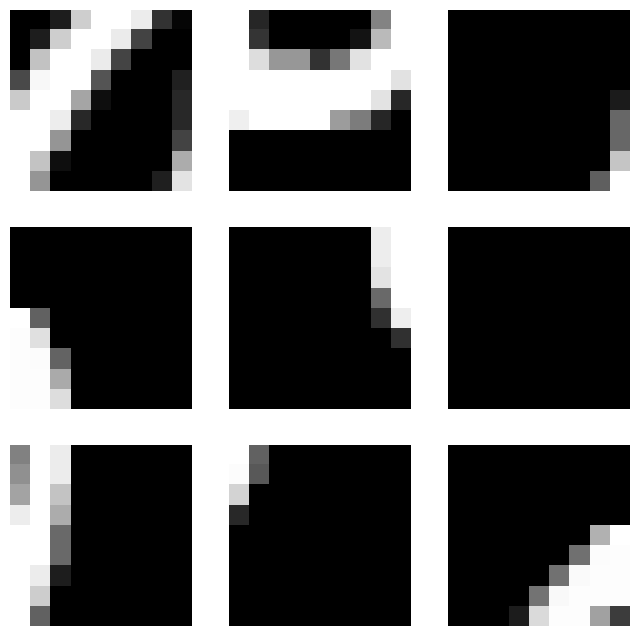

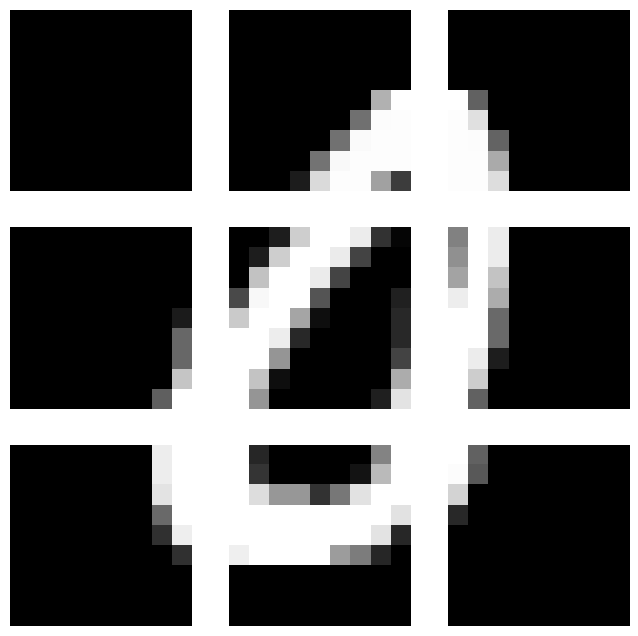

In [ ]:
import matplotlib.pyplot as plt

for tiles, order, label in train_loader:
  fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
  fig.subplots_adjust(hspace=.2)

  for i in range(3):
      for j in range(3):
          ax[i][j].axis('off')
          ax[i][j].imshow(tiles[0][i * 3 + j], cmap='gray')
  print(order)
  print(label)

  fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
  fig.subplots_adjust(hspace=.2)

  for i in range(3):
      for j in range(3):
          ax[i][j].axis('off')
          print((order[0]==i * 3 + j).nonzero(as_tuple=True)[0])
          ax[i][j].imshow(tiles[0][(order[0]==i * 3 + j).nonzero(as_tuple=True)[0].item()], cmap='gray')

  break

torch.Size([32, 3, 27, 27])
tensor(0.7500)


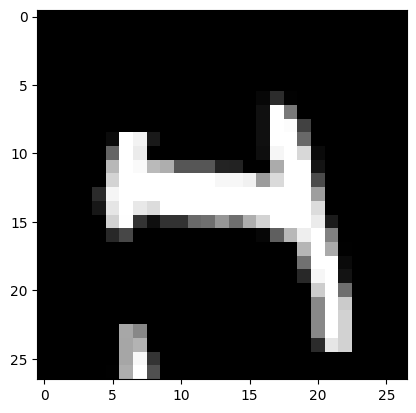

In [ ]:
for img, shuffles, label in train_loader_value:
  print(img.shape)
  plt.imshow(img[0,0,:,:], cmap='gray')
  print(shuffles[0])

  break

torch.Size([32, 3, 28, 28])
torch.Size([32, 3, 9, 9])
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8])
tensor([0, 8, 8, 8, 6, 3, 6, 0, 4, 6, 4, 1, 3, 7, 2, 0, 5, 3, 3, 1, 4, 6, 7, 1,
        2, 1, 3, 6, 4, 7, 0, 4])
tensor([3, 5, 2, 7, 8, 4, 1, 6, 0])


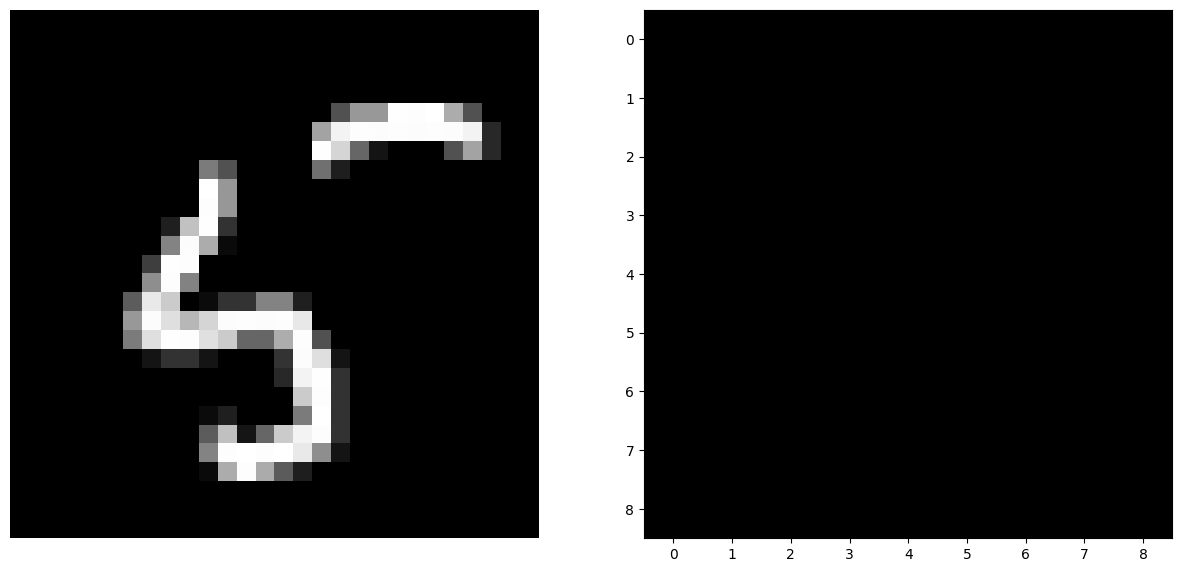

In [ ]:
for img, cur_pieces, tiles, tiles_shuffl, tile_list, order, label in train_loader_state:
  fig, ax = plt.subplots( ncols=2, figsize=(15,15))
  fig.subplots_adjust(hspace=.2)

  print(img.shape)
  print(tiles_shuffl.shape)
  # print(cur_pieces[0])
  ax[0].axis('off')
  ax[0].imshow(img[0,0,:,:], cmap='gray')
  print(cur_pieces)
  print(tile_list)
  print(order[0])
  ax[1].imshow(tiles_shuffl[0,0,:,:], cmap='gray')

  break

## Value Network

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.linear = nn.Linear(1000, 16)
        self.linear2 = nn.Linear(16, 1)
        self.softmax = nn.Softmax()
        self.flat = nn.Flatten()



    def forward(self, x):

        x = self.resnet(x)
        x = self.linear(x)
        x = self.linear2(x)
        # x = self.softmax(x)
        x = self.flat(x)
        x = torch.squeeze(x)

        return x

In [ ]:
# class ValueNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 28, kernel_size=(3,3), stride=1, padding=1)
#         self.act1 = nn.ReLU()
#         # self.drop1 = nn.Dropout(0.3)

#         self.conv2 = nn.Conv2d(28, 28, kernel_size=(3,3), stride=1, padding=1)
#         self.act2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

#         self.flat = nn.Flatten()

#         self.fc3 = nn.Linear(128, 16)
#         self.act3 = nn.ReLU()
#         # self.drop3 = nn.Dropout(0.1)

#         self.fc4 = nn.Linear(16, 1)
#         self.act4 = nn.Sigmoid()

#     def forward(self, x):
#         # input 3x32x32, output 32x32x32
#         x = self.act1(self.conv1(x))
#         # x = self.drop1(x)
#         # input 32x32x32, output 32x32x32
#         x = self.act2(self.conv2(x))
#         # input 32x32x32, output 32x16x16
#         x = self.pool2(x)
#         # input 32x16x16, output 8192
#         x = self.flat(x)
#         # input 8192, output 512
#         x = self.act3(self.fc3(x))
#         x = self.fc4(x)
#         x = self.act4(x)
#         return x

# Model Training

In [ ]:
Model_val = ValueNetwork()

In [ ]:
criterion_state = torch.nn.CrossEntropyLoss()
Model_state = JigsawModel()
optimizer_state = torch.optim.SGD(Model_state.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)


In [ ]:
def train_value(model, dataloader, optimizer, criterion, iter_number):

    model.train()
    optimizer.zero_grad()
    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    tot_error = 0
    total_loss  = 0
    error_percs = []
    losses = []
    for i, (images, labels, num_label) in enumerate(dataloader):

        # optimizer.zero_grad() # Zero gradients
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        # labels = torch.zeros((32,1), dtype=torch.float32)
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # print(outputs.shape)
        # print(labels.shape)
        tot_error     += float(sum((outputs - labels)**2))
        total_loss      += float(loss.item())
        error_perc         =100 * tot_error / (batch_size_train*(i + 1))
        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            error_perc         = "{:.04f}%".format(100 * tot_error / (batch_size_train*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            tot_error = tot_error,
            iter_number = iter_number
            # lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        if i % 10 == 0:
          losses.append(loss)
          error_percs.append(error_perc)
        # scaler.scale(loss).backward() # This is a replacement for loss.backward()
        # scaler.step(optimizer) # This is a replacement for optimizer.step()
        # scaler.update()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # for param in model.parameters():
        #   print(param.grad.data.sum())


        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    error_perc         = 100 * tot_error / (batch_size_train* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return error_perc, total_loss, losses, error_percs

In [ ]:
def validate_value(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    tot_error = 0.0
    total_loss = 0.0

    for i, (images, labels, num_label) in enumerate(dataloader):

        # Move images to device


        # Get model outputs
        with torch.inference_mode():
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          outputs = model(images)
          loss = criterion(outputs, labels)


        tot_error     += float(sum((outputs - labels)**2))
        total_loss      += float(loss.item())
        error_perc         =100 * tot_error / (batch_size_train*(i + 1))

        batch_bar.set_postfix(
            error_perc         = "{:.04f}%".format(100 * tot_error / (batch_size_train*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            tot_error = tot_error
            # lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        batch_bar.update()

    batch_bar.close()
    error_perc         = 100 * tot_error / (batch_size_train* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))
    return error_perc, total_loss

In [ ]:
criterion_value = torch.nn.MSELoss()
Model_val = ValueNetwork().to(DEVICE)
# summary(Model_val, (3, 27, 27))
optimizer_val = torch.optim.SGD(Model_val.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_errors = []
train_losses = []
val_errors = []
val_losses = []
test_errors = []
test_losses = []
a = []
b = []

In [ ]:
for i in range(11):
  err, total_loss, losses, error_percs = train_value(Model_val, train_loader_value, optimizer_val, criterion_value, i)
  train_errors.append(err)
  train_losses.append(total_loss)
  a.append(losses)
  b += error_percs
  torch.save({'model_state_dict':Model_val.state_dict(),
              'optimizer_state_dict':optimizer_val.state_dict()}, '/content/drive/MyDrive/11-785 Project/Models/model_value.pth')
  val_error, val_loss = validate_value(Model_val, val_loader_value, criterion_value)
  val_errors.append(val_error)
  val_losses.append(val_loss)

## Training Results

In [ ]:
print(validate_value(Model_val, val_loader_value, criterion_value))

(2.901614982581848, 0.029040089178148848)


In [ ]:
print(val_errors)

[2.8552196835553136, 2.4872643932647223, 2.2019749694234205, 2.1665470060920526, 2.051487016668593, 1.9604710644097803, 2.0658194419942784, 1.8474590303756786, 1.7901631805807563, 1.744661505332425, 1.7458351841775392, 1.7073726824933058, 1.624394588413951, 1.6464488797525, 1.636039430265634, 1.5593960576444255, 1.5990722464599363, 1.538544831190384, 1.5803497043135535, 1.5517863890794676, 1.5303495162221243, 1.5418388222412043, 1.5049932532005845, 1.4647004481563823, 1.4675821280222696, 1.463381384729307, 1.4592129239220284, 1.414381028698893, 1.397715718361349, 1.4206637615969877, 1.4623172444723163, 1.4208944489580595, 1.383787328931528, 1.4259359731502685, 1.350958836240095, 1.4337450551649897, 1.440598416848515, 1.3339378777560555, 1.3726230536225263, 1.3300907093416205, 1.336803371012277, 1.2745342379498756, 1.4101082276301475, 1.356644120206312, 1.331032165218654, 1.30441839323705, 1.313134039740606, 1.3536622488894376, 1.3134708961382588, 1.2827646444248926, 1.3118763586595574]

In [ ]:
print(train_errors)

[5.320916808744423, 3.1038962643641783, 2.6996521131679563, 2.58978751912906, 2.4938651000242467, 2.3739806109697468, 2.2917548129980516, 2.1713490642590187, 2.1819295808502672, 2.0960447010325276, 2.0132173956793884, 2.0456956057920657, 1.9867964184318825, 1.9067411355657244, 1.8778552306547862, 1.8311375236778498, 1.8221320453903553, 1.7871125422486211, 1.7591849787292686, 1.7216038914654128, 1.723500807795841, 1.688065034034467, 1.6579895226394095, 1.641130223529809, 1.6106221892623414, 1.5818960114218357, 1.5792026324233115, 1.5598164010588689, 1.5130468619375945, 1.531852074254727, 1.527639098397349, 1.5424039449453388, 1.5192268834423106, 1.4788599060288001, 1.5058873115945821, 1.4727084155876107, 1.4419506798354342, 1.432227413152307, 1.4531445002533716, 1.426189652341223, 1.4094234822262632, 1.4151988999835823, 1.412462737228259, 1.3885617965296115, 1.4061067194833228, 1.3677416847038502, 1.396380851392103, 1.362262432791877, 1.3826503259146137, 1.3649019971277114, 1.3348466206

In [ ]:
# model = ValueNetwork()
# model.load_state_dict('/content/drive/MyDrive/11-785 Project/Models/model_policy.pth')


In [ ]:
# torch.save({'model_state_dict':Model_val.state_dict(),
#             'optimizer_state_dict':optimizer_val.state_dict()}, '/content/drive/MyDrive/11-785 Project/Models/model_value.pth')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (%)')
plt.show()

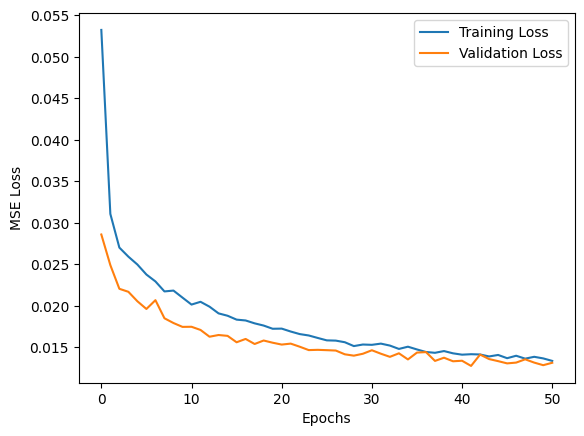

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()